<a href="https://www.kaggle.com/code/angelchaudhary/regime-shifts-vs-spikes-in-time-series?scriptVersionId=290389162" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Case Study: Detecting Structural Breaks, Not Noise

# Introduction
Time series data often shows sharp movements but not every spike or drop reflects a real change. Some fluctuations are short-term noise while others indicate a **structural break**, a moment when the underlying data generating process shifts. These breaks matter because models trained on historical data assume stability. When the world changes, those assumptions fail silently. In this case study, we focus on detecting **regime changes**, not just reacting to volatility.

---

## Problem Statement

The core problem is to **distinguish temporary shocks from true structural breaks** in a time series.

We aim to answer:
- How can we identify points where the statistical behavior of a time series changes?
- How does model performance differ **before vs after** a structural break?
- Why do models that once worked well degrade after regime shifts?

The goal is not only detection but understanding the **impact of structural breaks on model reliability**.

---

## Approach 

1. Select a real-world time series where regime changes are expected  
2. Visually inspect the series to identify potential break points  
3. Apply formal structural break detection methods  
4. Split the data into **pre-break** and **post-break** regimes  
5. Train the same forecasting model on each regime  
6. Compare model behavior and performance across regimes  

---

## What This Case Study Shows

- Why historical performance can be misleading  
- How regime shifts invalidate model assumptions  
- Why detecting structural change is more important than chasing short-term accuracy


# LET'S DO IT!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExNXR0Y212cWF1dTExMmJxdzFxN2dmczBjNWQ2MjJka2UxaW1nMGVtNSZlcD12MV9naWZzX3NlYXJjaCZjdD1n/LHZyixOnHwDDy/giphy.gif)

In [1]:
import kagglehub

path = kagglehub.dataset_download("visalakshiiyer/cpi-us-all-commodities")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cpi-us-all-commodities


In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("/kaggle/input/cpi-us-all-commodities/cpi_u_allitems_by_year_unseasoned.csv")

In [3]:
df.head()

,Unnamed: 0,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2
0,0,2000.0,168.8,169.8,171.2,171.3,171.5,172.4,172.8,172.8,173.7,174.0,174.1,174.0,172.2,170.8,173.6
1,1,2001.0,175.1,175.8,176.2,176.9,177.7,178.0,177.5,177.5,178.3,177.7,177.4,176.7,177.1,176.6,177.5
2,2,2002.0,177.1,177.8,178.8,179.8,179.8,179.9,180.1,180.7,181.0,181.3,181.3,180.9,179.9,178.9,180.9
3,3,2003.0,181.7,183.1,184.2,183.8,183.5,183.7,183.9,184.6,185.2,185.0,184.5,184.3,184.0,183.3,184.6
4,4,2004.0,185.2,186.2,187.4,188.0,189.1,189.7,189.4,189.5,189.9,190.9,191.0,190.3,188.9,187.6,190.2


In [4]:
# converting this into proper time-series
import pandas as pd

# Drop unnecessary column
df = df.drop(columns=['Unnamed: 0'])

# Convert from wide to long format
df_long = df.melt(id_vars=['Year'],value_vars=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
    var_name='Month',value_name='CPI')

# Create proper datetime column
df_long['Date'] = pd.to_datetime(df_long['Year'].astype(int).astype(str) + '-' + df_long['Month'],format='%Y-%b')

# Sort by time
df_long = df_long.sort_values('Date').reset_index(drop=True)

df_long.head()


,Year,Month,CPI,Date
0,2000.0,Jan,168.8,2000-01-01
1,2000.0,Feb,169.8,2000-02-01
2,2000.0,Mar,171.2,2000-03-01
3,2000.0,Apr,171.3,2000-04-01
4,2000.0,May,171.5,2000-05-01


## Visualizing the Time Series

Before applying any structural break detection methods, we visualize the CPI series to understand its overall trend and identify periods where the behavior appears to change. Visual inspection helps form initial hypotheses about possible regime shifts.


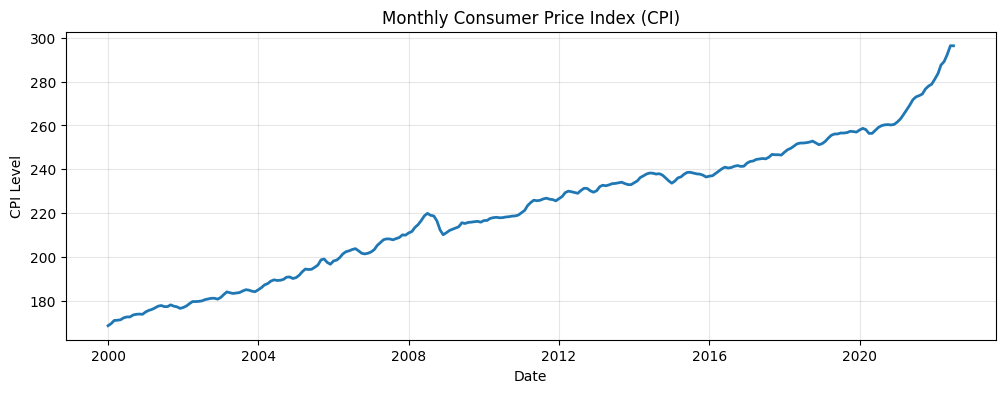

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df_long['Date'], df_long['CPI'], linewidth=2)
plt.title("Monthly Consumer Price Index (CPI)")
plt.xlabel("Date")
plt.ylabel("CPI Level")
plt.grid(True, alpha=0.3)
plt.show()


## Transforming CPI into Inflation

CPI levels are non-stationary and dominated by a long-term trend. To study regime changes in inflation dynamics, we transform the CPI series into a year-over-year (YoY) inflation rate. This removes the deterministic trend and highlights changes in inflation behavior over time.


In [6]:
# Compute YoY inflation (%)
df_long['Inflation_YoY'] = (df_long['CPI'].pct_change(periods=12) * 100)
df_long[['Date', 'Inflation_YoY']].dropna().head()

/tmp/ipykernel_17/388716857.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_long['Inflation_YoY'] = (df_long['CPI'].pct_change(periods=12) * 100)


,Date,Inflation_YoY
12,2001-01-01,3.732227
13,2001-02-01,3.533569
14,2001-03-01,2.920561
15,2001-04-01,3.269119
16,2001-05-01,3.615160


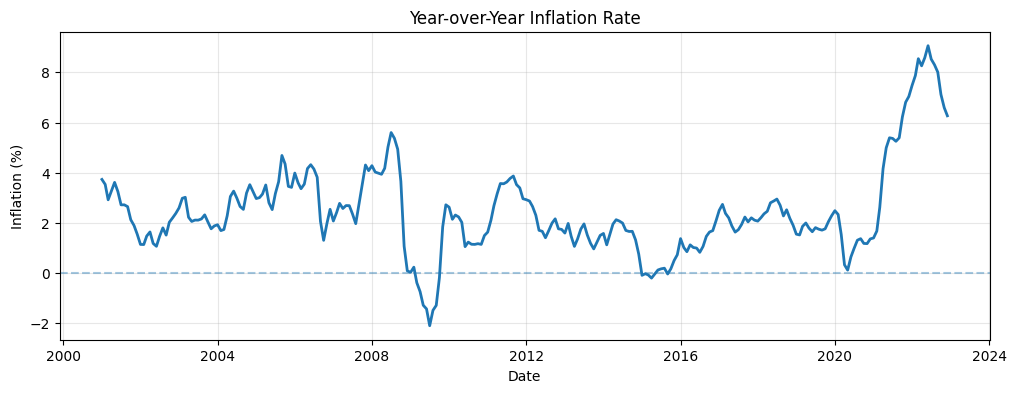

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(df_long['Date'], df_long['Inflation_YoY'], linewidth=2)
plt.axhline(0, linestyle='--', alpha=0.4)
plt.title("Year-over-Year Inflation Rate")
plt.xlabel("Date")
plt.ylabel("Inflation (%)")
plt.grid(True, alpha=0.3)
plt.show()

### Interpreting the Inflation Series

After transforming CPI into year-over-year inflation, the series no longer follows a smooth upward trend. Instead, we observe distinct periods with different average levels and volatility.
And we noticed,
- A sharp negative shock around the 2008 financial crisis
- A prolonged low-inflation regime during the mid-2010s
- A sudden and sustained high-inflation regime after 2020

These shifts suggest changes in the underlying inflation process rather than temporary noise, making this series suitable for structural break detection.

## Detecting Structural Breaks Using Rolling Statistics

A structural break often appears as a persistent change in the mean or volatility of a time series. To capture this, we compute rolling estimates of the inflation mean and standard deviation and examine how they evolve over time.


In [8]:
window = 36  # 3-year rolling window

df_long['rolling_mean'] = (df_long['Inflation_YoY'].rolling(window).mean())
df_long['rolling_std'] = (df_long['Inflation_YoY'].rolling(window).std())

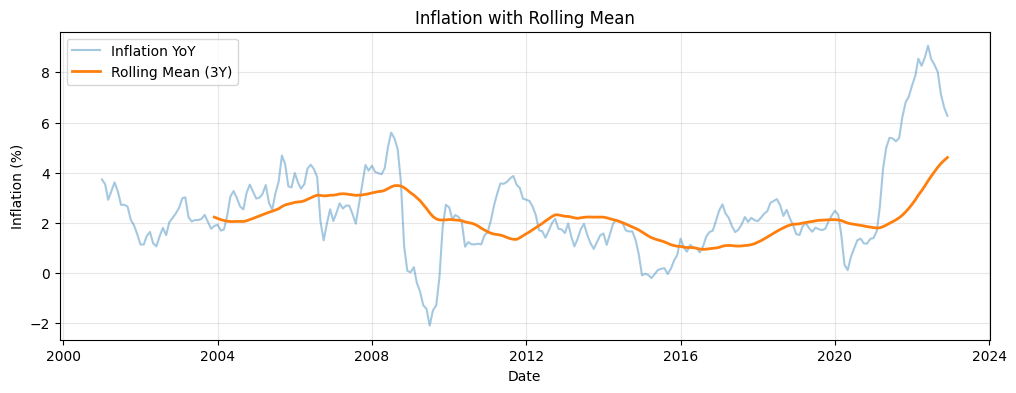

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(df_long['Date'], df_long['Inflation_YoY'], alpha=0.4, label='Inflation YoY')
plt.plot(df_long['Date'], df_long['rolling_mean'], linewidth=2, label='Rolling Mean (3Y)')
plt.title("Inflation with Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Inflation (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

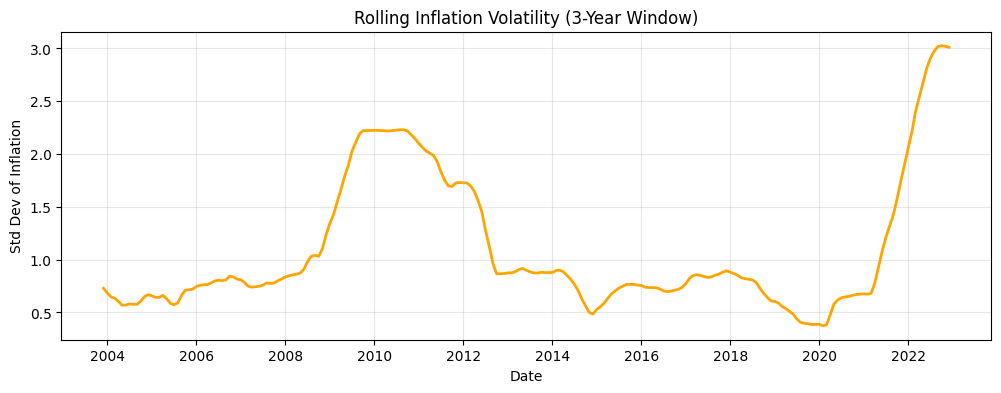

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(df_long['Date'], df_long['rolling_std'], linewidth=2, color='orange')
plt.title("Rolling Inflation Volatility (3-Year Window)")
plt.xlabel("Date")
plt.ylabel("Std Dev of Inflation")
plt.grid(True, alpha=0.3)
plt.show()


### Evidence of Structural Breaks

The rolling mean plot shows that inflation does not revert to a single long-run average. Instead, the average inflation level shifts across time, indicating regime changes rather than temporary deviations.

The rolling volatility plot further reinforces this. Inflation uncertainty remains low for extended periods and then rises sharply during crisis-driven regime shifts. Such sustained changes in both level and volatility are strong indicators of structural breaks in the inflation process.


## Before vs After the Structural Break

Detecting a structural break is only useful if it changes how models behave. To demonstrate this, we compare the performance of the same forecasting model before and after a major regime shift. We treat January 2020 as a structural break point and evaluate how a model trained on pre-2020 data performs when applied to the post-2020 inflation regime.


In [11]:
# Splitting the data
break_date = "2020-01-01"

pre_break = df_long[df_long['Date'] < break_date].copy()
post_break = df_long[df_long['Date'] >= break_date].copy()


In [12]:
# using pre-break mean inflation as a naive forecast
baseline_mean = pre_break['Inflation_YoY'].mean()

post_break['baseline_forecast'] = baseline_mean


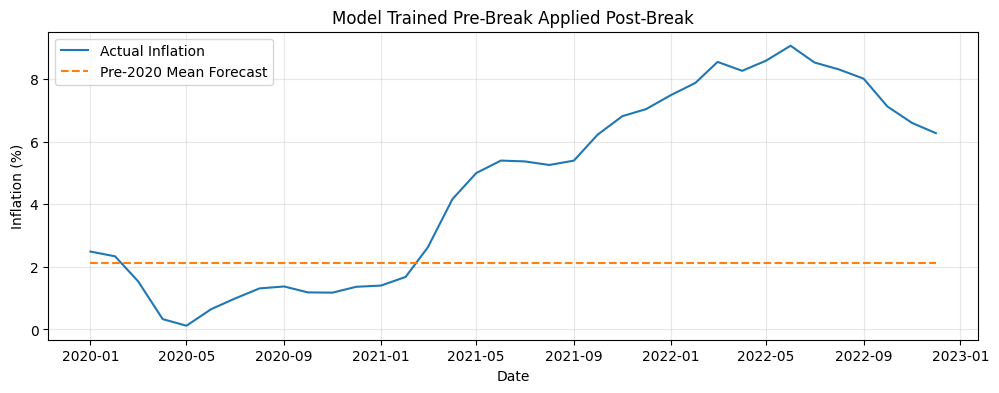

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(post_break['Date'], post_break['Inflation_YoY'], label='Actual Inflation')
plt.plot(post_break['Date'], post_break['baseline_forecast'], 
         linestyle='--', label='Pre-2020 Mean Forecast')
plt.title("Model Trained Pre-Break Applied Post-Break")
plt.xlabel("Date")
plt.ylabel("Inflation (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Why the Model Fails After the Break

The pre-2020 model produces a nearly constant forecast based on historical average inflation. While this approach worked reasonably well in earlier regimes, it consistently underestimates inflation in the post-2020 period.

The error is not random. Inflation rises sharply and remains elevated, while the model continues to assume a low-inflation environment. This mismatch highlights a core issue: the model is not wrong because it is simple, but because it is trained on a different regime. In the presence of structural breaks, past data no longer represents the future. As a result, models that ignore regime shifts can appear stable in historical evaluation yet fail when the underlying economic process changes.


In [14]:
# Quantify the failure
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(post_break['Inflation_YoY'],post_break['baseline_forecast'])
mae

3.1738636076046296

### Quantifying the Model Breakdown

The mean absolute error (MAE) of the pre-2020 model when applied to post-2020 data is approximately **3.17 percentage points**. Given that historical inflation typically fluctuated between 1–3%, this level of error is substantial. The model consistently underpredicts inflation throughout the post-break period, indicating a systematic failure rather than random noise. This confirms that the degradation in performance is driven by a structural change in the inflation regime. A model trained on past data cannot reliably generalize once the underlying data-generating process shifts.


## Conclusion

Structural breaks represent changes in how the world works, not just short-term volatility. This case study demonstrates that ignoring regime shifts leads to models that appear accurate in historical evaluation but fail when deployed in a new regime. Detecting and responding to structural breaks is therefore essential for building reliable time-series forecasting systems.
